## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [107]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

In [1]:
import pandas as pd

file_name="data/data_000637.txt"
data=pd.read_csv(file_name)

#N must be smaller than or equal to the maximum number of rows and larger that 10k.
N = 20000

df = data[0:N].copy()
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
19995,1,0,27,3869200366,2513,29
19996,1,0,63,3869200366,2517,6
19997,1,0,32,3869200366,2519,5
19998,1,0,17,3869200366,2522,21


2\. Find out the number of BX in a ORBIT (the value 'x').

In [27]:
column = data["BX_COUNTER"]
x = column.max()+1
print(x)

3564


3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

In [28]:
max_ = data["ORBIT_CNT"].max()
min_ = data["ORBIT_CNT"].min()

diff = max_ - min_
time = diff*x*25*(10**-9)
print("The acquisition, up to row", N, "lasted",time, "s")

The acquisition, up to row 20000 lasted 0.9804564 s


4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

In [11]:
#Values in ORBIT_CNT (like 'hours') change (+1) when BX_COUNTER (like 'minute') reaches x (like 60 minutes)
#When TDC_MEAS (like 'second') reaches 30 (i.e. 25 ns), then BX_COUNTER+=1 and TDC_MEAS -> 0

df['ABSOLUTE_TIME'] = (df['ORBIT_CNT']*x*30 +df['BX_COUNTER']*30 + df['TDC_MEAS']) *25/30
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABSOLUTE_TIME
0,1,0,123,3869200167,2374,26,3.447457e+14
1,1,0,124,3869200167,2374,27,3.447457e+14
2,1,0,63,3869200167,2553,28,3.447457e+14
3,1,0,64,3869200167,2558,19,3.447457e+14
4,1,0,64,3869200167,2760,25,3.447457e+14
...,...,...,...,...,...,...,...
19995,1,0,27,3869200366,2513,29,3.447458e+14
19996,1,0,63,3869200366,2517,6,3.447458e+14
19997,1,0,32,3869200366,2519,5,3.447458e+14
19998,1,0,17,3869200366,2522,21,3.447458e+14


5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

In [12]:
import random
import numpy as np

lst = [random.randint(0,1) for i in range(N)]
array = np.array(lst)
df.loc[:,'HEAD'] = lst
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABSOLUTE_TIME
0,1,0,123,3869200167,2374,26,3.447457e+14
1,1,0,124,3869200167,2374,27,3.447457e+14
2,0,0,63,3869200167,2553,28,3.447457e+14
3,1,0,64,3869200167,2558,19,3.447457e+14
4,0,0,64,3869200167,2760,25,3.447457e+14
...,...,...,...,...,...,...,...
19995,0,0,27,3869200366,2513,29,3.447458e+14
19996,0,0,63,3869200366,2517,6,3.447458e+14
19997,0,0,32,3869200366,2519,5,3.447458e+14
19998,0,0,17,3869200366,2522,21,3.447458e+14


6\. Create a new DataFrame that contains only the rows with HEAD=1.

In [13]:
data1 = df[df['HEAD'] == 1]
data1

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABSOLUTE_TIME
0,1,0,123,3869200167,2374,26,3.447457e+14
1,1,0,124,3869200167,2374,27,3.447457e+14
3,1,0,64,3869200167,2558,19,3.447457e+14
5,1,0,63,3869200167,2762,4,3.447457e+14
6,1,0,61,3869200167,2772,14,3.447457e+14
...,...,...,...,...,...,...,...
19981,1,0,40,3869200366,1951,18,3.447458e+14
19984,1,0,59,3869200366,1973,19,3.447458e+14
19985,1,0,50,3869200366,1979,22,3.447458e+14
19987,1,0,62,3869200366,1980,28,3.447458e+14


7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

HEAD
TDC_CHANNEL FPGA      
1           0        6
            1      223
2           0       13
            1      253
3           0        6
...                ...
126         1        4
127         1        9
128         1       13
139         0      577
            1      250

[243 rows x 1 columns]

FPGA
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

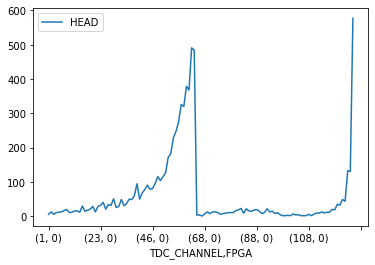

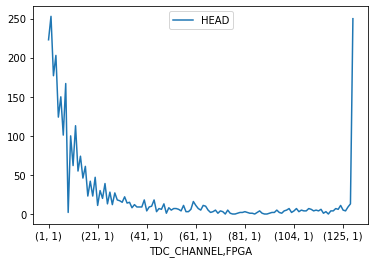

In [14]:
import IPython
#df.sort_values(by="TDC_CHANNEL")
#df.groupby(['HEAD'])
data2 = df.groupby(['TDC_CHANNEL','FPGA'])[['HEAD']].sum()
IPython.display.display(data2)
data2.groupby(['FPGA']).plot()

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

In [17]:
data3 = df.groupby(['TDC_CHANNEL','HEAD'])[['HEAD']].sum()
data3.nlargest(3,'HEAD')

,,HEAD
TDC_CHANNEL,HEAD,
139,1,827
63,1,496
64,1,495


9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [84]:
print("The number of unique orbits is",len(df['ORBIT_CNT'].value_counts()))

data3 = pd.DataFrame(df[df['TDC_CHANNEL']==139])
print("The number of unique orbits with at least one measurement from TDC_CHANNEL = 139 is:",len(df['ORBIT_CNT'].value_counts()))
IPython.display.display(data3)

The number of unique orbits is 200
The number of unique orbits with at least one measurement from TDC_CHANNEL = 139 is: 200


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABSOLUTE_TIME
7,0,0,139,3869200167,2776,0,3.447457e+14
15,1,1,139,3869200167,2797,0,3.447457e+14
30,0,0,139,3869200167,3085,0,3.447457e+14
39,1,0,139,3869200167,3186,0,3.447457e+14
48,0,0,139,3869200168,23,0,3.447457e+14
...,...,...,...,...,...,...,...
19934,0,0,139,3869200365,2275,0,3.447458e+14
19944,0,0,139,3869200365,2653,0,3.447458e+14
19952,1,0,139,3869200365,2780,0,3.447458e+14
19968,0,0,139,3869200366,682,0,3.447458e+14
